**Srishti Sharma**

---



# Sleep stage classification from polysomnography (PSG) data

This problem is tackled as multiclass classification task which comes under Supervised Learning. The aim is to predict the sleep stage from 5 possible stages for each chunk of 30 seconds of data.

In [32]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
!pip install pyEDFlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from mne.datasets.sleep_physionet.age import fetch_data

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

In [35]:
import mne
from mne.datasets.sleep_physionet.age import fetch_data

MNE-Python provides us with mne.datasets.sleep_physionet.age.fetch_data() to conveniently download data from the Sleep Physionet dataset

-> PSG.edf contains the polysomnography i.e, the raw data from the EEG helmet,

-> Hypnogram.edf contains the annotations recorded by an expert.

# Read the PSG data and Hypnograms to create a raw object

The following block of code fetches sleep data from the PhysioNet database for two subjects (ALICE and BOB) and plots the data using MNE. It reads in the EDF file for the first subject and the corresponding annotation file, sets the annotations on the raw data object, and plots the data for the first minute.

ALICE,BOB =0,1 ---> these variables are used as a way to specify which subjects to fetch data for. ALICE refers to the first subject, while BOB refers to the second subject.

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


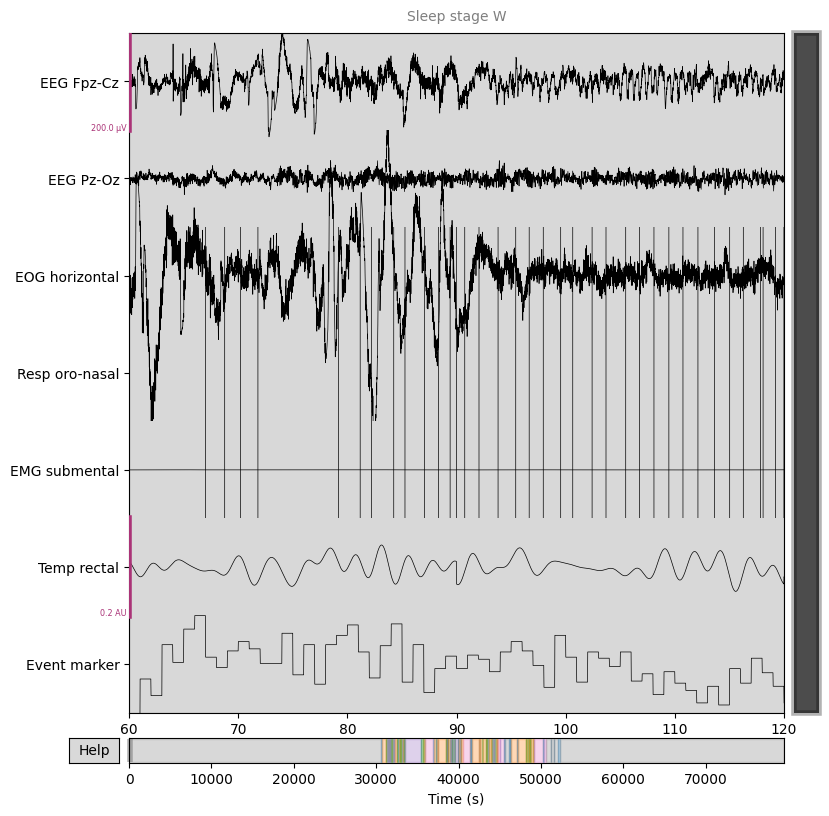

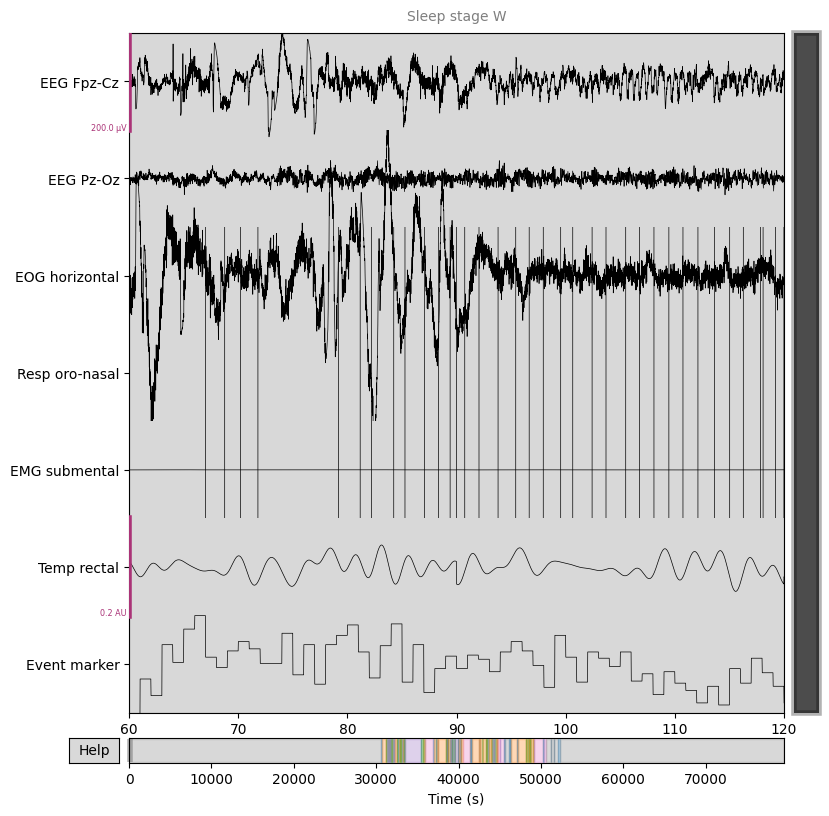

In [36]:
ALICE, BOB = 0, 1

[alice_files, bob_files] = fetch_data(subjects=[ALICE, BOB], recording=[1])

raw_train = mne.io.read_raw_edf(alice_files[0], stim_channel='Event marker', misc=['Temp rectal'])
annot_train = mne.read_annotations(alice_files[1])

raw_train.set_annotations(annot_train, emit_warning=False)
raw_train.plot(start=60, duration=60, scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7, misc=1e-1))

# Feature Explanation:


1. EEG Fpz-Cz and EEG Fpz-Cz both are vertical spiltting of brain
2. EOG horizontal: Eye movement
3. Resp oro-nasal: Oral respiratory
4. EMG submental: ElectroMyoGraphy https://behavenet.com/electromyogram
5. Temp rectal: upward movement while sleeping
6. Event marker: https://neuroimage.usc.edu/brainstorm/Tutorials/EventMarkers

The Sleep Physionet dataset comprises of 8 labels: Wake (W), Stage 1, Stage 2, Stage 3, Stage 4 corresponding to the range from light sleep to deep sleep, REM sleep (R) where REM is the abbreviation for Rapid Eye Movement sleep, movement (M), and Stage (?) for any none scored segment.

For the purpose of this project, i'm using 5 stages: Wake (W), Stage 1, Stage 2, Stage 3/4, and REM sleep (R).

 To do so, i've used the event_id parameter in mne.events_from_annotations() to select which events are we interested in and i've associated an event identifier to each of them.

Moreover, the recordings contain long awake (W) regions before and after each night. To limit class imbalance impact, we trim each recording by only keeping 30 minutes of wake time before the first occurrence and 30 minutes after the last occurrence of sleep stages.

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


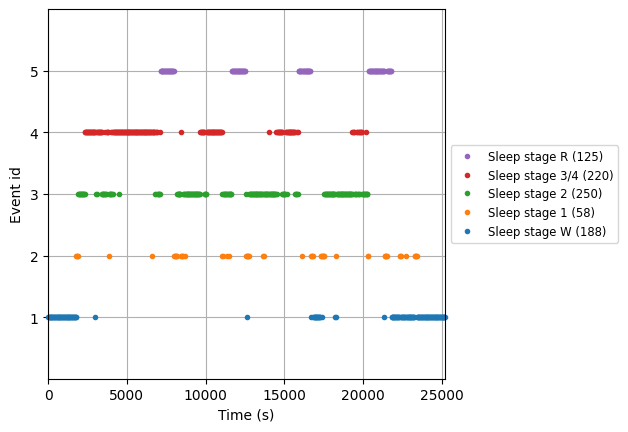

In [37]:
annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
annot_train.crop(annot_train[1]['onset'] - 30 * 60,
                 annot_train[-2]['onset'] + 30 * 60)
raw_train.set_annotations(annot_train, emit_warning=False)

events_train, _ = mne.events_from_annotations(
    raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.)

# create a new event_id that unifies stages 3 and 4
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

# plot events
fig = mne.viz.plot_events(events_train, event_id=event_id,
                          sfreq=raw_train.info['sfreq'],
                          first_samp=events_train[0, 0])

# keep the color-code for further plotting
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In the code above, the annotations of raw_train are cropped to keep only the last 30-min wake events before sleep and the first 30-min wake events after sleep.

Then, events_train are extracted from these annotations using mne.events_from_annotations() function with chunk_duration of 30 seconds and event_id defined by the dictionary annotation_desc_2_event_id. Finally, the event_id is updated to unify stages 3 and 4.


Then we'll plot the events extracted from the annotations and color-code them based on the event_id dictionary. We use the plot_events function from mne.viz. The events_train argument is the NumPy array of shape (n_events, 3) containing the onset, duration, and event ID of each event.

The event_id argument is the dictionary mapping event descriptions to event IDs. The sfreq argument is the sampling frequency of the data, and first_samp is the sample offset of the first sample in events_train with respect to raw_train. 
 
The stage_colors variable is used to store the color-code for each sleep stage for later use in plotting.





# Creating Epochs from the data based on the events found in the annotation

In [38]:
tmax = 30. - 1. / raw_train.info['sfreq']  # tmax in included

epochs_train = mne.Epochs(raw=raw_train, events=events_train, 
                          event_id=event_id, tmin=0., tmax=tmax, baseline=None)

print(epochs_train)

Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  841 events (good & bad), 0 - 29.99 sec, baseline off, ~12 kB, data not loaded,
 'Sleep stage W': 188
 'Sleep stage 1': 58
 'Sleep stage 2': 250
 'Sleep stage 3/4': 220
 'Sleep stage R': 125>


The code block above creates epochs from the raw data based on the events extracted from the annotations.

The **tmax variable** is calculated as 30 seconds minus 1 sample period (which is 1/sfreq, where sfreq is the sampling frequency of the raw data), and it is used to define the duration of each epoch.

The **mne.Epochs() function** creates epochs object from the raw data, using the **events_train array** and the **event_id dictionary** to determine the events and their corresponding labels. The **tmin** parameter is set to 0 (since we want to start each epoch at the beginning of the event), and the tmax parameter is set to the value calculated above.

The **baseline** parameter is set to None, which means that no baseline correction will be applied to the data.
 If you want to apply a baseline correction, you can set this parameter to a tuple of two values, representing the time interval to use for baseline correction (e.g., baseline=(None, 0) will use the entire epoch for baseline correction, while baseline=(-0.5, 0) will use the 500 ms preceding the event onset).


The print(epochs_train) statement simply prints information about the epochs object, including the number of epochs, the number of channels, and the time interval covered by each epoch.

# Repeating the steps for Bob

In [39]:
raw_test = mne.io.read_raw_edf(bob_files[0], stim_channel='Event marker',
                               misc=['Temp rectal'])
annot_test = mne.read_annotations(bob_files[1])
annot_test.crop(annot_test[1]['onset'] - 30 * 60,
                annot_test[-2]['onset'] + 30 * 60)
raw_test.set_annotations(annot_test, emit_warning=False)
events_test, _ = mne.events_from_annotations(
    raw_test, event_id=annotation_desc_2_event_id, chunk_duration=30.)
epochs_test = mne.Epochs(raw=raw_test, events=events_test, event_id=event_id,
                         tmin=0., tmax=tmax, baseline=None)

print(epochs_test)

Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1103 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  1103 events (good & bad), 0 - 29.99 sec, baseline off, ~12 kB, data not loaded,
 'Sleep stage W': 157
 'Sleep stage 1': 109
 'Sleep stage 2': 562
 'Sleep stage 3/4': 105
 'Sleep stage R': 170>


The 'epochs_test object' contains the epoched data for Bob's sleep recording. It was created using the same event IDs as the 'epochs_train object', and with the same epoch duration of 30 seconds.

The raw data was read from Bob's EDF file, and annotations were read from a separate file and cropped to include only the last 30 minutes of wakefulness before sleep onset and the first 30 minutes of wakefulness after sleep offset. 

Finally, the 'mne.events_from_annotations()' function was used to extract the events from the annotations and create an events array, which was used to create the epochs_test object using the 'mne.Epochs()' function.

# Feature Engineering

With the help of visualizing power spectral density (PSD) plot of the epochs grouped by sleeping stage we observe that different sleep stages have different signatures. These signatures remain similar between Alice and Bob’s data.



In [40]:
# visualize Alice vs. Bob PSD by sleep stage.
fig, (ax1, ax2) = plt.subplots(ncols=2)

# iterate over the subjects
stages = sorted(event_id.keys())
for ax, title, epochs in zip([ax1, ax2],
                             ['Alice', 'Bob'],
                             [epochs_train, epochs_test]):

    for stage, color in zip(stages, stage_colors):
        spectrum = epochs[stage].compute_psd(fmin=0.1, fmax=20.)
        spectrum.plot(ci=None, color=color, axes=ax,
                      show=False, average=True, spatial_colors=False)
    ax.set(title=title, xlabel='Frequency (Hz)')
ax1.set(ylabel='µV²/Hz (dB)')
ax2.legend(ax2.lines[2::3], stages)

Loading data for 58 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 250 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 220 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 125 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 188 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Loading data for 109 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Av

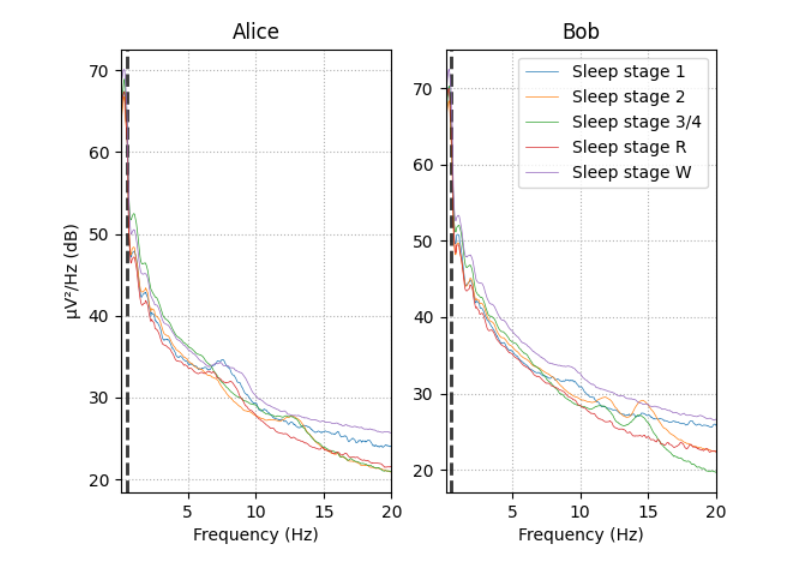

The code is plotting the Power Spectral Density (PSD) for each sleep stage of Alice and Bob using the MNE library. The PSD is computed for each frequency band (from 0.1 to 20 Hz).

The left plot is for Alice, and the right plot is for Bob. For each subject, there are five curves corresponding to each sleep stage, and they have different colors. The x-axis represents the frequency in Hz, and the y-axis represents the power spectral density in µV²/Hz (dB). The legend on the right of the right plot shows the different sleep stages and their corresponding colors.

This visualization allows us to compare the PSD of each sleep stage of Alice and Bob and see if there are any differences.

# Design a scikit-learn transformer from a Python function

We will now create a function to extract EEG features based on relative power in specific frequency bands to be able to predict sleep stages from EEG signals.

In [41]:
def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 30]}

    spectrum = epochs.compute_psd(picks='eeg', fmin=0.5, fmax=30.)
    psds, freqs = spectrum.get_data(return_freqs=True)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

This function takes an mne.Epochs object and creates EEG features based on relative power in specific frequency bands. It returns a numpy array of shape [n_samples, 5], where n_samples is the number of epochs in the input Epochs object, and the 5 columns represent the average relative power in the delta, theta, alpha, sigma, and beta frequency bands, respectively.

The function first computes the power spectral density (PSD) of the EEG data using the **compute_psd()** method of the Epochs object.

 It uses the **picks parameter** to select only the EEG channels and sets the frequency range to [0.5, 30] Hz using the fmin and fmax parameters. It then normalizes the PSDs by dividing each PSD by the sum of all PSDs in that epoch.


Next, the function computes the average relative power in each of the frequency bands defined in the **FREQ_BANDS** dictionary. For each frequency band, it selects the corresponding frequencies from the freqs array and averages the PSDs across those frequencies for each epoch. It then flattens the resulting array and adds it to a list of feature arrays.

Finally, the function concatenates the feature arrays along the column axis using 'np.concatenate()' and returns the resulting numpy array.

# Multiclass classification workflow using scikit-learn

We can predict Bob’s sleeping stages based on Alice’s data. In order to justify this we will take advantage of two key features of scikit-learn: Pipeline , and FunctionTransformer.

Scikit-learn pipeline composes an estimator as a sequence of transforms and a final estimator, while the FunctionTransformer converts a python function in an estimator compatible object. 

In [42]:
pipe = make_pipeline(FunctionTransformer(eeg_power_band, validate=False),
                     RandomForestClassifier(n_estimators=100, random_state=42))

# Train
y_train = epochs_train.events[:, 2]
pipe.fit(epochs_train, y_train)

# Test
y_pred = pipe.predict(epochs_test)

# Assess the results
y_test = epochs_test.events[:, 2]
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))

Loading data for 841 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 1103 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Accuracy score: 0.6745240253853128


The code creates a machine learning pipeline with scikit-learn's **make_pipeline()** function. The pipeline consists of two steps:

1.**FunctionTransformer(eeg_power_band, validate=False)** - this is a preprocessing step that transforms the input data (epochs) using the eeg_power_band function defined earlier. This function extracts EEG features based on relative power in specific frequency bands.

2.**RandomForestClassifier(n_estimators=100, random_state=42)** - this is a classifier that uses random forest algorithm with 100 trees.


The pipeline is trained on the 'epochs_train data', where the target variable is extracted from the events array using the third column (epochs_train.events[:, 2]).

 The pipeline is then used to predict the sleep stage for the 'epochs_test data', and the accuracy of the predictions is calculated using scikit-learn's 'accuracy_score() function'.

The true labels for the epochs_test data are extracted in the same way as for the epochs_train data (epochs_test.events[:, 2]).

In [43]:
print(confusion_matrix(y_test, y_pred))

[[154   1   0   2   0]
 [ 80   4   4   2  19]
 [ 84  19 394  25  40]
 [  0   0   3 102   0]
 [ 56   5  18   1  90]]


In [44]:
print(classification_report(y_test, y_pred, target_names=event_id.keys()))

                 precision    recall  f1-score   support

  Sleep stage W       0.41      0.98      0.58       157
  Sleep stage 1       0.14      0.04      0.06       109
  Sleep stage 2       0.94      0.70      0.80       562
Sleep stage 3/4       0.77      0.97      0.86       105
  Sleep stage R       0.60      0.53      0.56       170

       accuracy                           0.67      1103
      macro avg       0.57      0.64      0.57      1103
   weighted avg       0.72      0.67      0.67      1103



In [45]:
!pip install --upgrade yasa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 22.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.6/423.6 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.3 MB/s eta 0:00:00
  Created wheel for yasa: filename=yasa-0.6.3-py3-none-any.whl size=

# Sleep stages

**Stage 1 Sleep**

Stage 1 sleep is called light or transition sleep. It is the transition from wakefulness to sleep. It is characterized by the gradual slowing of the EEG. Often patients will be awake, with eyes closed and demonstrate alpha rhythms as they slip into stage 1. This rhythm begins to slowly widen and slow and take on the characteristics of theta rhythm. Theta activity comprises most of the EEG activity in stage 1.
Besides theta waves, one is apt also to see occasional vertex sharp waves. There are no spindles or K complexes in this stage. In observing the eyes, one also notes slow rolling eye movements, each stretching more than several seconds long. These are more prominent in the early portion of stage 1, but gradually disappear as this phase progresses. Myoclonic twitches of the limb muscles may occur. Once alpha rhythms decrease to less than 50% of the epoch and theta rhythms occupy more than 50%, stage 1 can be scored. Stage 1 sleep occupies between 5% and 7% of a normal subject’s total sleep time.

**Stage 2 Sleep**

Stage 2 sleep begins with the appearance of spindles and K complexes. The background frequency is between 1 Hz and 5 Hz and is of low amplitude. Since K complexes and spindles are intermittent phenomena, a time factor must be considered in order to properly score this stage. Known as the 3 Minute Rule, this factor states that if more than 3 minutes elapse since the time of the last K complex or sleep spindle, then the intervening epochs are scored as Stage 1. If less than 3 minutes (6 x 30-second epochs) pass before another K complex or spindle occurs, then the intervening epochs continue to be scored as stage 2. If movement artifact or stage wake appears within 3 minutes, then the stage is still scored as stage 2 but only up to the point of the arousal. After an arousal, scoring rules reset themselves and the resuming epochs are scored as stage 1 until a K complex or spindle appears again. It is very important to keep track of the epoch scores that proceeded the epoch under consideration. Stage 2 usually occupies about 50% of a normal night’s sleep time.

**Delta Sleep—Stages 3 and 4**

Delta sleep is also known as slow wave sleep (SWS) or deep sleep. It is comprised of both stages 3 and 4. These are characterized by slow, high amplitude waves with a frequency of less than 2 Hz and an amplitude of at least 75 mV. K complexes and spindles may be present throughout delta sleep but may be obscured. This type of sleep makes up about 25% of a normal adult’s sleep. In children, teenagers, and young adults, it may be much more prevalent. Stage 3 is present when between 20% and 50% of an epoch is composed of delta waves, although sometimes it can be difficult to discern between stage 2 and stage 3. In order to quantify the amount of an epoch that is comprised of delta waves, one must measure the width of each waveform and add them together to determine the time axis occupied. Stage 4 sleep is present when more than 50% of an epoch is composed of delta waves.

**REM Sleep**

REM sleep is often referred to as paradoxical or active sleep. It is the sleep stage when dreaming occurs. If present, the EEG drops to a mixed frequency, mostly low voltage recording. One can differentiate between stage 1 and REM by looking at the chin EMG lead. The amplitude in stage REM is extremely low whereas it is higher in stage 1. In fact, during REM the chin EMG should be at its lowest point of the whole night. Short phasic twitches of the limb muscles may occur during REM, although normal individuals are completely paralyzed during REM.
Another factor that helps to diagnose REM is the presence of rapid eye movements that appear intermittently throughout this stage. Respiratory variation as well as cardiac sinus arrhythmia can be present, especially during phasic REM. Spindles also occur on occasion during REM, which can make differentiating between REM and stage 2 a little more difficult. As long as the time between spindles is 3 minutes or more, the stage is scored as REM. EMG tone is the ultimate arbiter in many cases. Comparing chin tone during stage 2 and the stage in question is helpful. Sawtooth waves can also sometimes be seen during REM. These are waves that have a narrowed, triangular appearance running at frequencies of 2 Hz to 6 Hz and at amplitudes between 40 mV and 100 mV. They usually occur for a few seconds at a time.